In [10]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import resnet
import keras.backend as K
from helpers import f1
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [11]:
model = resnet(256, 256, 3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 128, 128, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 128, 128, 64)         256       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_10 (ReLU)             (None, 128, 128, 64)         0         ['batch_normalization_12

In [12]:
# Images generator (RGB)
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    'data_v3_processed/train/images',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='rgb',
    seed=42)

# Masks generator (grayscale, single channel)
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data_v3_processed/train/masks',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

Found 7350 images belonging to 2 classes.
Found 7350 images belonging to 2 classes.


In [13]:
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    'data_v3_processed/val/images',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='rgb',
    seed=42,
    shuffle = False,)

# Masks generator (grayscale, single channel)
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data_v3_processed/val/masks',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='grayscale',
    seed=42,
    shuffle = False,)

Found 108 images belonging to 1 classes.
Found 108 images belonging to 1 classes.


In [14]:
def combine_generator(image_generator, mask_generator):
    while True:
        for img_batch, mask_batch in zip(image_generator, mask_generator):
            yield img_batch, mask_batch

train_generator = combine_generator(train_image_generator, train_mask_generator)
val_generator = combine_generator(val_image_generator, val_mask_generator)

In [15]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=1,
                    steps_per_epoch=3000,
                    validation_steps=13)

3000/3000 [==============================] - 60s 18ms/step - loss: 0.0057 - f1: 0.6327 - val_loss: 0.0223 - val_f1: 0.5884


In [16]:
import cv2
import numpy as np

img = cv2.imread('data_v3_processed/test/images/images/28_05_08_11.png')
mask = cv2.imread('data_v3_processed/test/masks/masks/28_05_08_11.tif')

img_np = np.array(img)
img_np = np.expand_dims(img_np, axis=0)
img_np = img_np / 255

pred = model.predict(img_np)

1/1 [==============================] - 0s 450ms/step


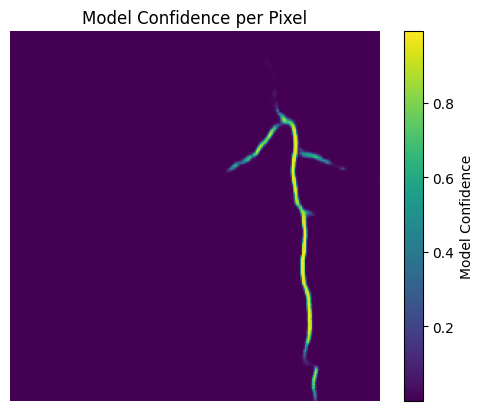

In [17]:
import matplotlib.pyplot as plt

confidence_map = pred[0, :, :, 0]  # Remove batch and channel dims

plt.imshow(confidence_map, cmap='viridis')
plt.colorbar(label="Model Confidence")
plt.title("Model Confidence per Pixel")
plt.axis('off')
plt.show()

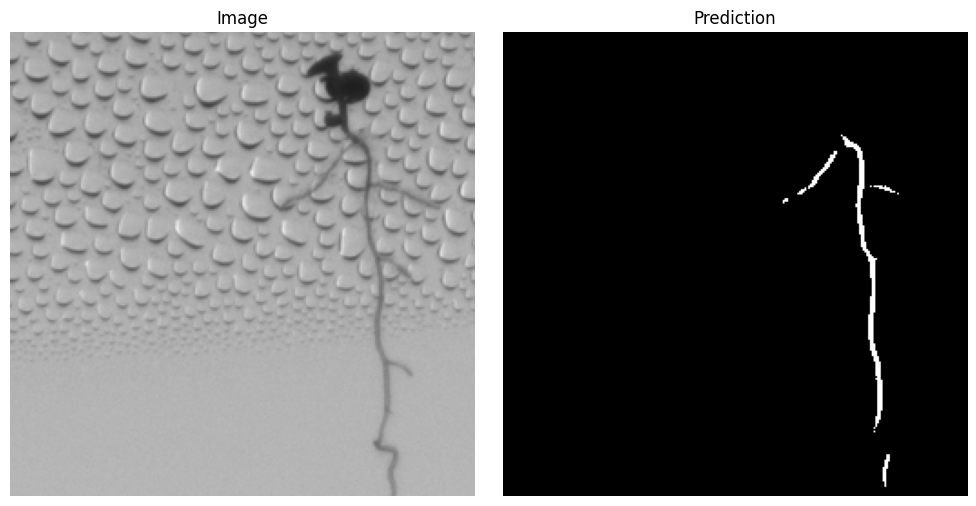

In [18]:
pred = (pred > 0.5).astype(np.uint8)

pred_img = np.squeeze(pred, axis=0)
pred_vis = (pred_img * 255).astype(np.uint8)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # width x height in inches

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_vis, cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
model.save("resnet_model.h5")